# DATA CLEANING

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import plotly.express as px
from IPython.display import Markdown, display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import folium

%matplotlib inline

In [3]:
df = pd.read_csv("kc_house_data.csv")
df.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors waterfront  view  ...          grade sqft_above  \
0      5650     1.0        NaN  NONE  ...      7 Average       1180   
1      7242     2.0         NO  NONE  ...      7 Average       2170   
2     10000     1.0         NO  NONE  ...  6 Low Average        770   
3      5000     1.0         NO  NONE  ...      7 Average       1050   
4      8080     1.0         NO  NONE  ...         8 Good       1680   

   sqft_basement yr_built  yr_renovated  zipcode      lat     long  \
0            0.0     1955           0.0    98178  47.5112 -122.257   
1          400.0     1951        1991.0    98125  47.7210 -122.319   
2            0.0     1933           NaN    98028  47.7379 -122.233   
3          910.0     1965           0.0    98136  47.5208 -122.393   
4            0.0     1987           0.0    98074  47.6168 -122.045   

   sqft_living15  sqft_lot15  
0           1340        5650  
1           1690        7639  
2           2720        8062  
3           1360        5000  
4           1800        7503  

[5 rows x 21 columns]

In [4]:
# adding FLOOR TO AREA ratio column 

df["FAR"] = df["sqft_living"] / df["sqft_lot"]

In [5]:
# checking and filling in nan values

#print(df["view"].unique())
#pint(df["waterfront"].unique())
#pint(df["yr_renovated"].unique())

df["view"] = df["view"].fillna("NONE")
df["waterfront"] = df["waterfront"].fillna("NO")
df["yr_renovated"] = df["yr_renovated"].fillna(0)

In [6]:
# changing categorical columns to numerical 

#print(df["grade"].sort_values().unique())
#print(df["condition"].unique())

df["grade"].replace(to_replace = {"10 Very Good": "10", "11 Excellent": "11", "12 Luxury": "12", "13 Mansion": "13", "3 Poor": "3", "4 Low": "4", "5 Fair": "5", "6 Low Average": "6", "7 Average": "7", "8 Good": "8", "9 Better": "9"}, inplace = True)
df["condition"].replace(to_replace = {"Poor": "1", "Fair": "2", "Average": "3", "Good": "4", "Very Good": "5"}, inplace = True)
df["view"].replace(to_replace = {"NONE": "0", "FAIR": "1", "AVERAGE": "2", "GOOD": "3", "EXCELLENT": "4"}, inplace = True)
df["waterfront"].replace(to_replace = {"YES": "1", "NO": "0"}, inplace = True)

# changing "grade", "condition", "view" data type to int
df["grade"] = df["grade"].astype(int)
df["condition"] = df["condition"].astype(int)
df["view"] = df["view"].astype(int)
df["waterfront"] = df["waterfront"].astype(int)
df["yr_renovated"] = df["yr_renovated"].astype(int)

# changing "date" data type to datatime 
df["date"] = pd.to_datetime(df["date"])

In [7]:
df["sqft_basement"].value_counts(ascending = False)

# changing ? values in sqft_basement 

df["sqft_basement"] = df["sqft_living"] - df["sqft_above"]

# changing "sqft_basement" data type to int
df["sqft_basement"] = df["sqft_basement"].astype(float)

In [8]:
# changing yr renovated to binary

df["year_renovated"] = np.where(df["yr_renovated"] > 0, True, False)
df["year_renovated"] = np.where(df["year_renovated"] == True, 1, 0)

In [9]:
# dropping row with 33 bedrooms

df.drop(df[df["bedrooms"] == 33].index, inplace = True)

# dropping yr renovated 

del df["yr_renovated"]

In [10]:
# adding zoning column using FAR and level of floors

df["zoning"] = np.where((df["FAR"] <= 0.5) & (df["floors"] <= 2.0), "single", "multi")
df["zoning"] = np.where(df["zoning"] == "single", 1, 2)

In [11]:
# creating a separate dataframe filtered by FAR and zoning  
# used unique zipcodes from filtered df1 and applied it on the original dataframe
# filtered it more by removing zipcodes where the most expensive and cheap houses are located

df1 = df.loc[(df["FAR"] < 0.5) & (df["zoning"] == 2)]
zipswewant = df1["zipcode"].unique().tolist()

df1_filtered_by_unique_zips = df[df['zipcode'].isin(zipswewant)]
df1_filtered_by_unique_zips

# dropping zipcodes with cheapest and most expensive houses
df1_filtered_by_unique_zips = df1_filtered_by_unique_zips[df1_filtered_by_unique_zips["zipcode"] != 98102]
df1_filtered_by_unique_zips = df1_filtered_by_unique_zips[df1_filtered_by_unique_zips["zipcode"] != 98001]
df1_filtered_by_unique_zips = df1_filtered_by_unique_zips[df1_filtered_by_unique_zips["zipcode"] != 98040]
df1_filtered_by_unique_zips = df1_filtered_by_unique_zips[df1_filtered_by_unique_zips["zipcode"] != 98112]

# these are all the unique zipcodes containing the most underutilized land and is most likely densely populated at the same time
print(len(df1_filtered_by_unique_zips["zipcode"].unique()))

42


In [12]:
# creating month column 

df1_filtered_by_unique_zips['month'] = pd.to_datetime(df1_filtered_by_unique_zips['date']).dt.month
df1_filtered_by_unique_zips

id       date      price  bedrooms  bathrooms  sqft_living  \
1      6414100192 2014-12-09   538000.0         3       2.25         2570   
3      2487200875 2014-12-09   604000.0         4       3.00         1960   
4      1954400510 2015-02-18   510000.0         3       2.00         1680   
5      7237550310 2014-05-12  1230000.0         4       4.50         5420   
9      3793500160 2015-03-12   323000.0         3       2.50         1890   
...           ...        ...        ...       ...        ...          ...   
21591  2997800021 2015-02-19   475000.0         3       2.50         1310   
21592   263000018 2014-05-21   360000.0         3       2.50         1530   
21594  1523300141 2014-06-23   402101.0         2       0.75         1020   
21595   291310100 2015-01-16   400000.0         3       2.50         1600   
21596  1523300157 2014-10-15   325000.0         2       0.75         1020   

       sqft_lot  floors  waterfront  view  ...  yr_built  zipcode      lat  \
1          7242     2.0           0     0  ...      1951    98125  47.7210   
3          5000     1.0           0     0  ...      1965    98136  47.5208   
4          8080     1.0           0     0  ...      1987    98074  47.6168   
5        101930     1.0           0     0  ...      2001    98053  47.6561   
9          6560     2.0           0     0  ...      2003    98038  47.3684   
...         ...     ...         ...   ...  ...       ...      ...      ...   
21591      1294     2.0           0     0  ...      2008    98116  47.5773   
21592      1131     3.0           0     0  ...      2009    98103  47.6993   
21594      1350     2.0           0     0  ...      2009    98144  47.5944   
21595      2388     2.0           0     0  ...      2004    98027  47.5345   
21596      1076     2.0           0     0  ...      2008    98144  47.5941   

          long  sqft_living15  sqft_lot15       FAR  year_renovated  zoning  \
1     -122.319           1690        7639  0.354874               1       1   
3     -122.393           1360        5000  0.392000               0       1   
4     -122.045           1800        7503  0.207921               0       1   
5     -122.005           4760      101930  0.053174               0       1   
9     -122.031           2390        7570  0.288110               0       1   
...        ...            ...         ...       ...             ...     ...   
21591 -122.409           1330        1265  1.012365               0       2   
21592 -122.346           1530        1509  1.352785               0       2   
21594 -122.299           1020        2007  0.755556               0       2   
21595 -122.069           1410        1287  0.670017               0       2   
21596 -122.299           1020        1357  0.947955               0       2   

       month  
1         12  
3         12  
4          2  
5          5  
9          3  
...      ...  
21591      2  
21592      5  
21594      6  
21595      1  
21596     10  

[14890 rows x 24 columns]

In [13]:
display(Markdown("column_names.md"))

# Column Names and Descriptions for King County Data Set
* `id` - Unique identifier for a house
* `date` - Date house was sold
* `price` - Sale price (prediction target)
* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms
* `sqft_living` - Square footage of living space in the home
* `sqft_lot` - Square footage of the lot
* `floors` - Number of floors (levels) in house
* `waterfront` - Whether the house is on a waterfront
  * Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts
* `view` - Quality of view from house
  * Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
* `condition` - How good the overall condition of the house is. Related to maintenance of house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each condition code
* `grade` - Overall grade of the house. Related to the construction and design of the house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each building grade code
* `sqft_above` - Square footage of house apart from basement
* `sqft_basement` - Square footage of the basement
* `yr_built` - Year when house was built
* `yr_renovated` - Year when house was renovated
* `zipcode` - ZIP Code used by the United States Postal Service
* `lat` - Latitude coordinate
* `long` - Longitude coordinate
* `sqft_living15` - The square footage of interior housing living space for the nearest 15 neighbors
* `sqft_lot15` - The square footage of the land lots of the nearest 15 neighbors


In [14]:
df1_filtered_by_unique_zips.describe()

id         price      bedrooms     bathrooms   sqft_living  \
count  1.489000e+04  1.489000e+04  14890.000000  14890.000000  14890.000000   
mean   4.613726e+09  5.491564e+05      3.366353      2.133277   2102.670651   
std    2.882256e+09  3.092869e+05      0.893726      0.759221    910.627007   
min    1.200019e+06  8.000000e+04      1.000000      0.500000    370.000000   
25%    2.141311e+09  3.520000e+05      3.000000      1.750000   1440.000000   
50%    3.952200e+09  4.800000e+05      3.000000      2.250000   1940.000000   
75%    7.237488e+09  6.610000e+05      4.000000      2.500000   2600.000000   
max    9.900000e+09  5.110000e+06     10.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  1.489000e+04  14890.000000  14890.000000  14890.000000  14890.000000   
mean   1.546059e+04      1.515682      0.005306      0.228274      3.417663   
std    4.227366e+04      0.547102      0.072648      0.756599      0.657037   
min    6.000000e+02      1.000000      0.000000      0.000000      1.000000   
25%    5.000000e+03      1.000000      0.000000      0.000000      3.000000   
50%    7.384500e+03      1.500000      0.000000      0.000000      3.000000   
75%    1.050000e+04      2.000000      0.000000      0.000000      4.000000   
max    1.651359e+06      3.500000      1.000000      4.000000      5.000000   

       ...      yr_built       zipcode           lat          long  \
count  ...  14890.000000  14890.000000  14890.000000  14890.000000   
mean   ...   1971.538214  98081.614238     47.578978   -122.210809   
std    ...     29.806739     50.297734      0.138686      0.136283   
min    ...   1900.000000  98005.000000     47.155900   -122.416000   
25%    ...   1951.000000  98034.000000     47.513025   -122.337000   
50%    ...   1977.000000  98074.000000     47.601150   -122.205000   
75%    ...   1998.000000  98118.000000     47.689900   -122.102000   
max    ...   2015.000000  98199.000000     47.777600   -121.315000   

       sqft_living15     sqft_lot15           FAR  year_renovated  \
count   14890.000000   14890.000000  14890.000000     14890.00000   
mean     2010.109940   13185.556078      0.333415         0.03358   
std       694.971417   28694.499318      0.271698         0.18015   
min       399.000000     659.000000      0.000610         0.00000   
25%      1500.000000    5000.000000      0.160337         0.00000   
50%      1860.000000    7438.000000      0.257877         0.00000   
75%      2400.000000    9975.000000      0.421588         0.00000   
max      6210.000000  871200.000000      2.187500         1.00000   

             zoning         month  
count  14890.000000  14890.000000  
mean       1.185964      6.582807  
std        0.389090      3.110718  
min        1.000000      1.000000  
25%        1.000000      4.000000  
50%        1.000000      6.000000  
75%        1.000000      9.000000  
max        2.000000     12.000000  

[8 rows x 23 columns]

In [15]:
df1_filtered_by_unique_zips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14890 entries, 1 to 21596
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              14890 non-null  int64         
 1   date            14890 non-null  datetime64[ns]
 2   price           14890 non-null  float64       
 3   bedrooms        14890 non-null  int64         
 4   bathrooms       14890 non-null  float64       
 5   sqft_living     14890 non-null  int64         
 6   sqft_lot        14890 non-null  int64         
 7   floors          14890 non-null  float64       
 8   waterfront      14890 non-null  int32         
 9   view            14890 non-null  int32         
 10  condition       14890 non-null  int32         
 11  grade           14890 non-null  int32         
 12  sqft_above      14890 non-null  int64         
 13  sqft_basement   14890 non-null  float64       
 14  yr_built        14890 non-null  int64         
 15  zi

In [16]:
# variables of interest

df1_filtered_by_unique_zips[df1_filtered_by_unique_zips.columns[1:]].corr()['price'][:]

price             1.000000
bedrooms          0.318550
bathrooms         0.526480
sqft_living       0.704935
sqft_lot          0.106579
floors            0.256627
waterfront        0.315961
view              0.438323
condition         0.007080
grade             0.676091
sqft_above        0.603772
sqft_basement     0.309413
yr_built          0.070170
zipcode          -0.000863
lat               0.289348
long              0.031039
sqft_living15     0.589052
sqft_lot15        0.097739
FAR               0.097191
year_renovated    0.089388
zoning            0.127850
month            -0.011236
Name: price, dtype: float64

In [17]:
df1_filtered_by_unique_zips.shape

(14890, 24)

In [18]:
# groupby zipcode using mean price 

df_by_zipcode_mean = df1_filtered_by_unique_zips.groupby("zipcode").agg({"price": "mean", 
                            "bedrooms": "mean",
                            "bathrooms": "mean",
                            "sqft_living": "mean", 
                            "sqft_lot": "mean",
                            "FAR": "mean", 
                            "grade": "mean", 
                            "condition": "mean",
                            "view": "mean", 
                            "FAR": "mean", 
                            "month": "count"})
print(df_by_zipcode_mean.index)


Int64Index([98005, 98006, 98007, 98010, 98014, 98022, 98023, 98024, 98027,
            98029, 98030, 98033, 98034, 98038, 98042, 98052, 98053, 98056,
            98059, 98072, 98074, 98075, 98077, 98092, 98103, 98105, 98109,
            98115, 98116, 98117, 98118, 98122, 98125, 98126, 98133, 98136,
            98144, 98155, 98166, 98177, 98188, 98199],
           dtype='int64', name='zipcode')


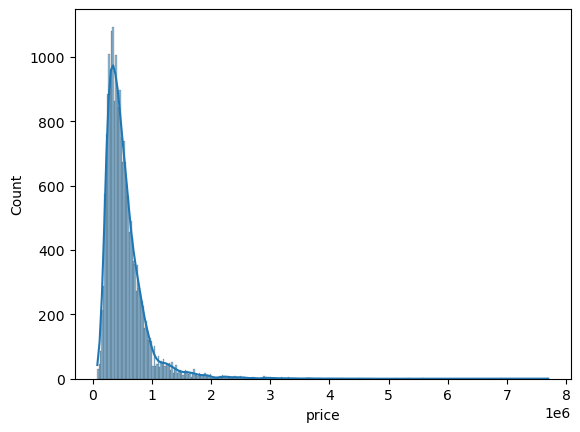

In [19]:
# histplot to see the distribution of price

sns.histplot(data = df, x = "price", kde = True)
plt.show();

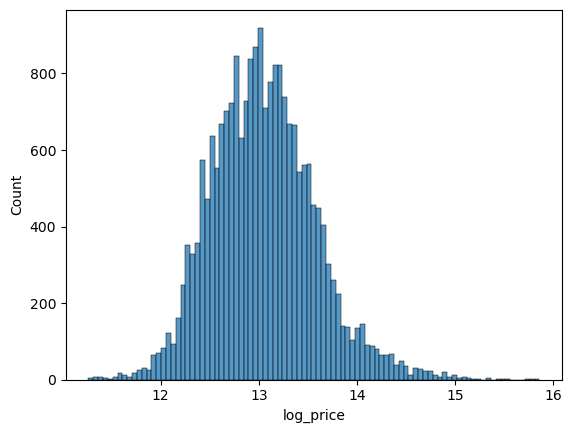

In [20]:
# histogram of normalized price 

df['log_price'] = np.log(df['price'])

sns.histplot(data = df1_filtered_by_unique_zips, x = df["log_price"])
plt.show();

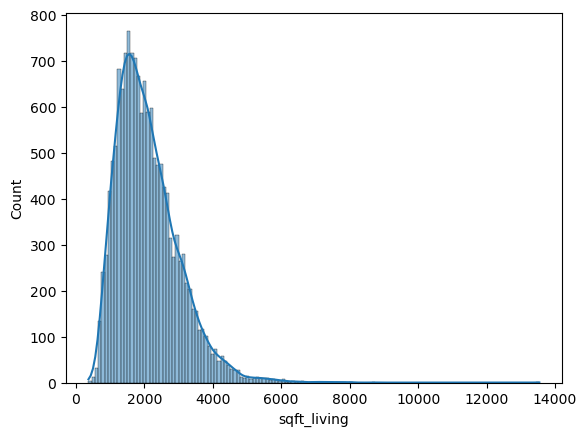

In [21]:
# checking the skewness of each sqft_living

sns.histplot(data = df1_filtered_by_unique_zips, x = "sqft_living", kde = True)
plt.show()

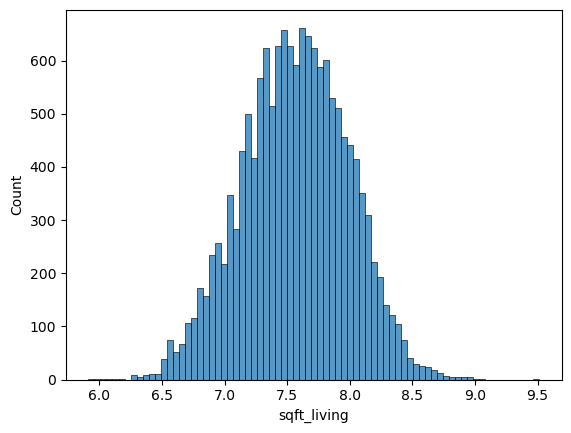

In [22]:
# histogram of normalized sqft_living

sns.histplot(data = df1_filtered_by_unique_zips, x = np.log(df1_filtered_by_unique_zips["sqft_living"]))
plt.show();

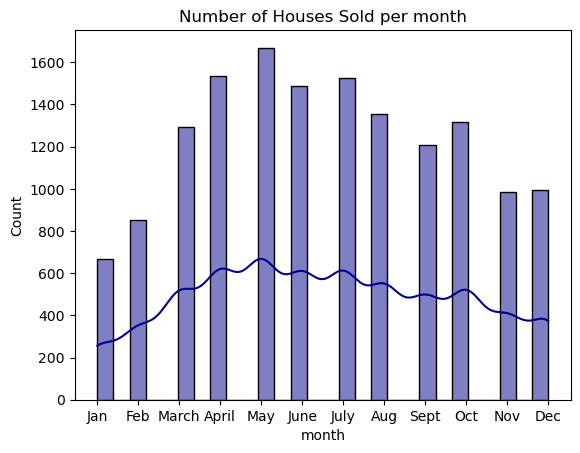

In [23]:
# number of houses sold per month 
fig, ax = plt.subplots()
ax = sns.histplot(data = df1_filtered_by_unique_zips, x = "month", color = "DarkBlue", kde = True)
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax.set_xticklabels(["Jan", "Feb", "March", "April", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"])
plt.title("Number of Houses Sold per month")
plt.show();

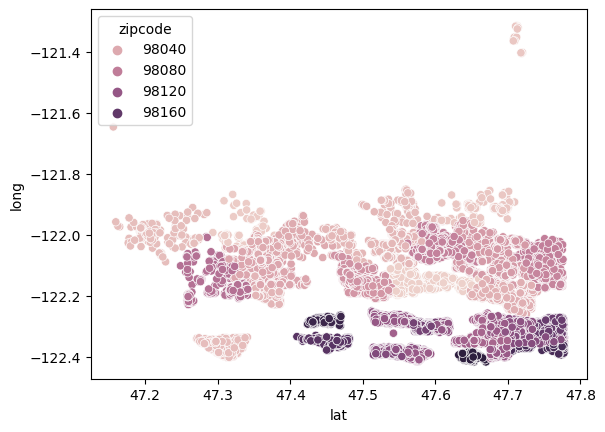

In [24]:
# 
sns.scatterplot(data = df1_filtered_by_unique_zips, x = "lat", y = "long", hue = "zipcode")
plt.show()

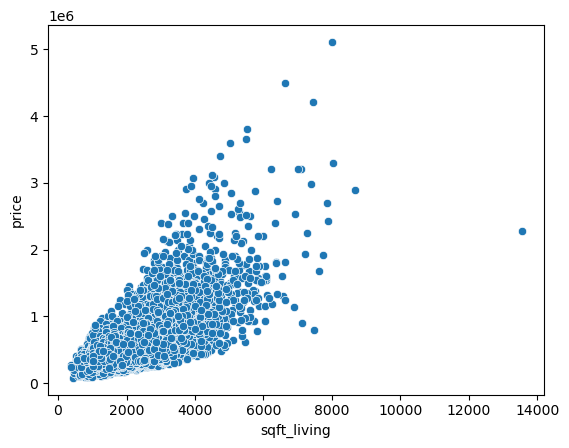

In [25]:
# price vs sqft_living

sns.scatterplot(data = df1_filtered_by_unique_zips, x = "sqft_living", y = "price")
plt.show();

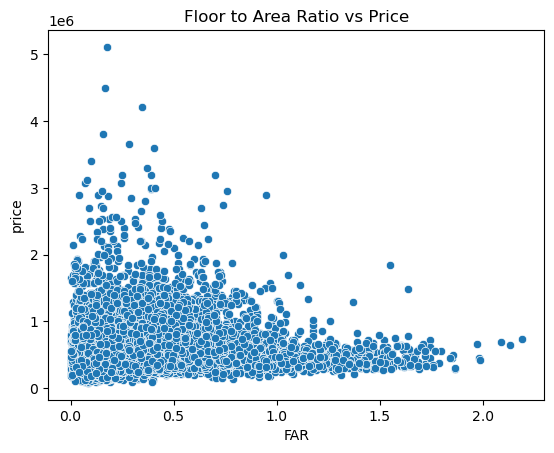

In [26]:
# price vs FAR 

sns.scatterplot(data = df1_filtered_by_unique_zips, x = "FAR", y = "price")
plt.title("Floor to Area Ratio vs Price")
plt.show();

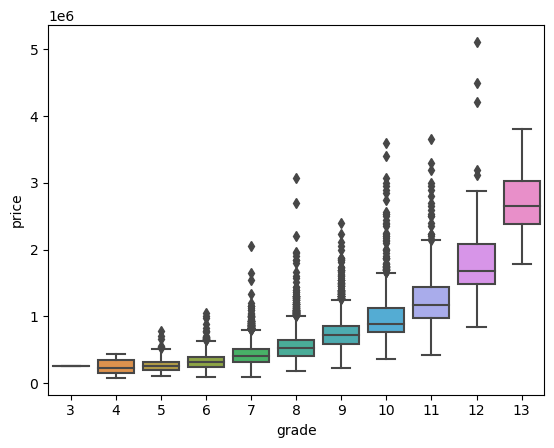

In [27]:
# price vs grade

sns.boxplot(data = df1_filtered_by_unique_zips, x = "grade", y = "price")
plt.show()

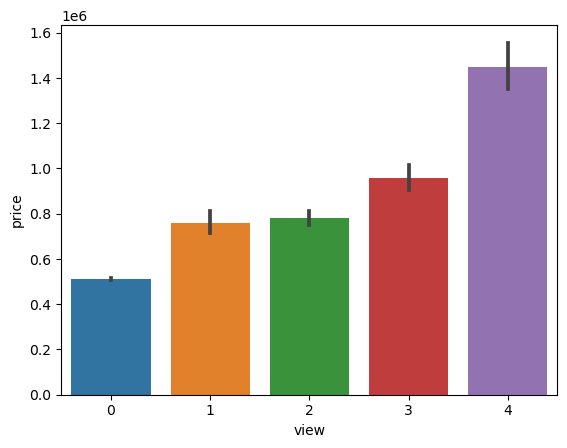

In [28]:
# price vs view

sns.barplot(data = df1_filtered_by_unique_zips, x = "view", y = "price")
plt.show();

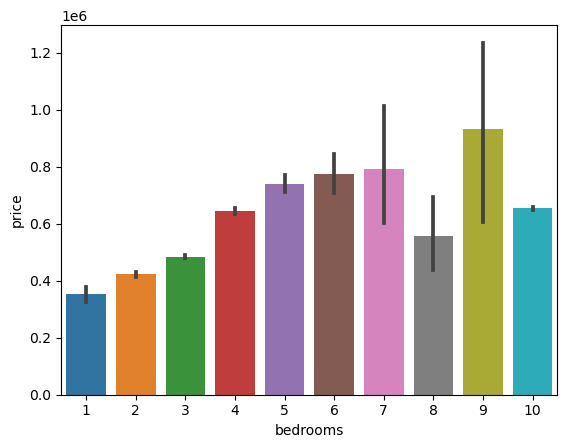

In [29]:
# price vs bedrooms

sns.barplot(data = df1_filtered_by_unique_zips, x = "bedrooms", y = "price")
plt.show();

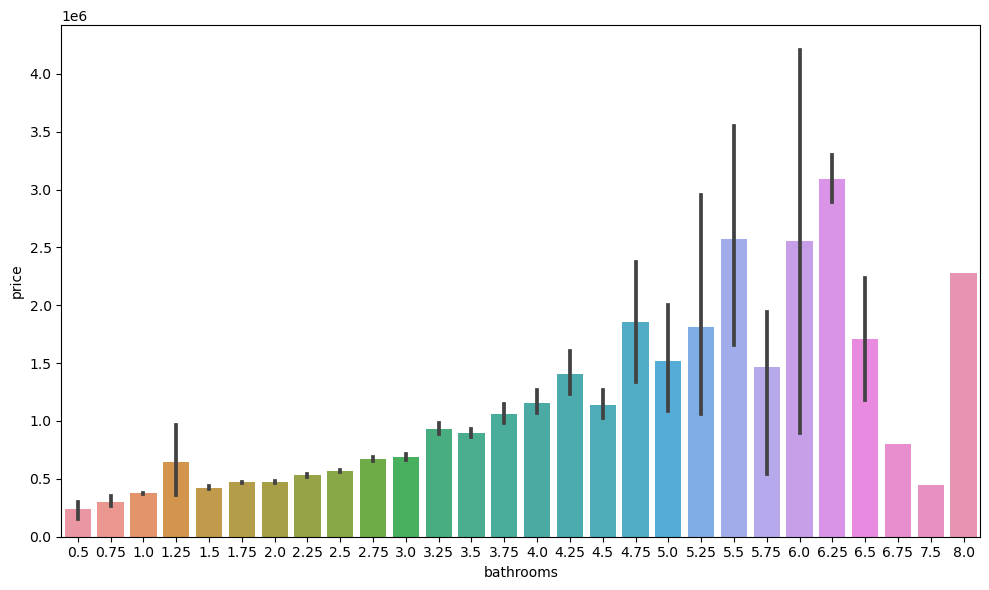

In [30]:
# price vs bathrooms
fig, ax = plt.subplots(figsize = (10, 6))
ax = sns.barplot(data = df1_filtered_by_unique_zips, x = "bathrooms", y = "price")
plt.tight_layout()
plt.show();

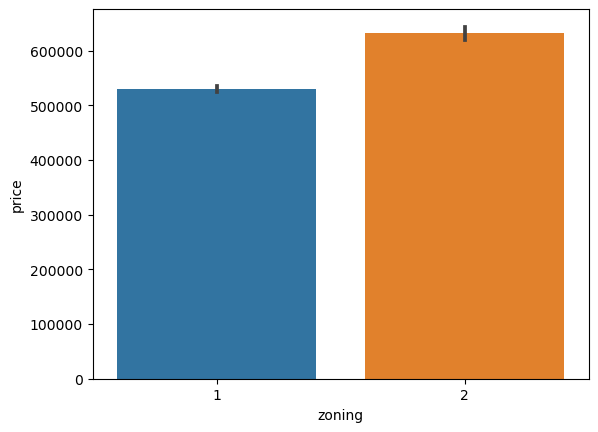

In [31]:
# price vs zoning

sns.barplot(data = df1_filtered_by_unique_zips, x = "zoning", y = "price")
plt.show();

In [32]:
df_by_zipcode_mean
df_by_zipcode_mean_shrunked = df_by_zipcode_mean.nlargest(10, "FAR")

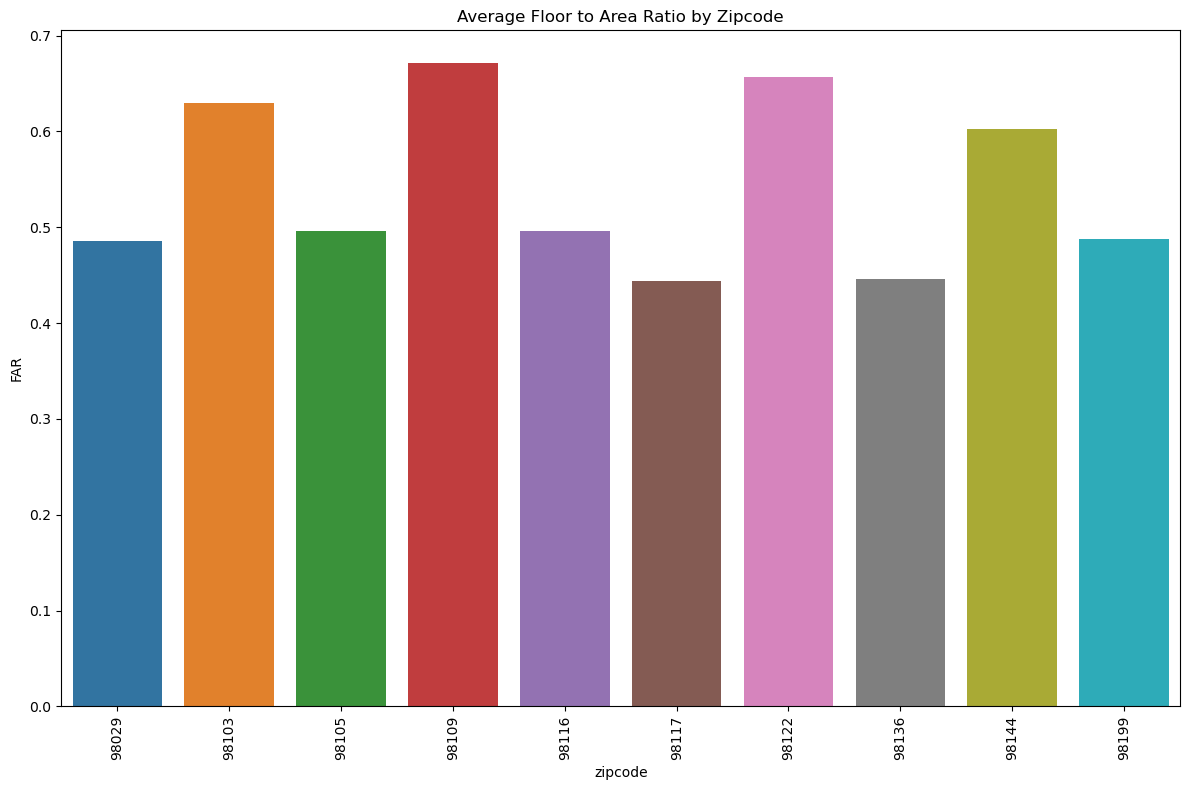

In [33]:
fig, ax = plt.subplots(figsize = (12, 8))

sns.barplot(data = df_by_zipcode_mean_shrunked, 
            x = df_by_zipcode_mean_shrunked.index,
            y = "FAR",
            estimator = np.mean,
            ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.title("Average Floor to Area Ratio by Zipcode")
plt.tight_layout()
plt.show();

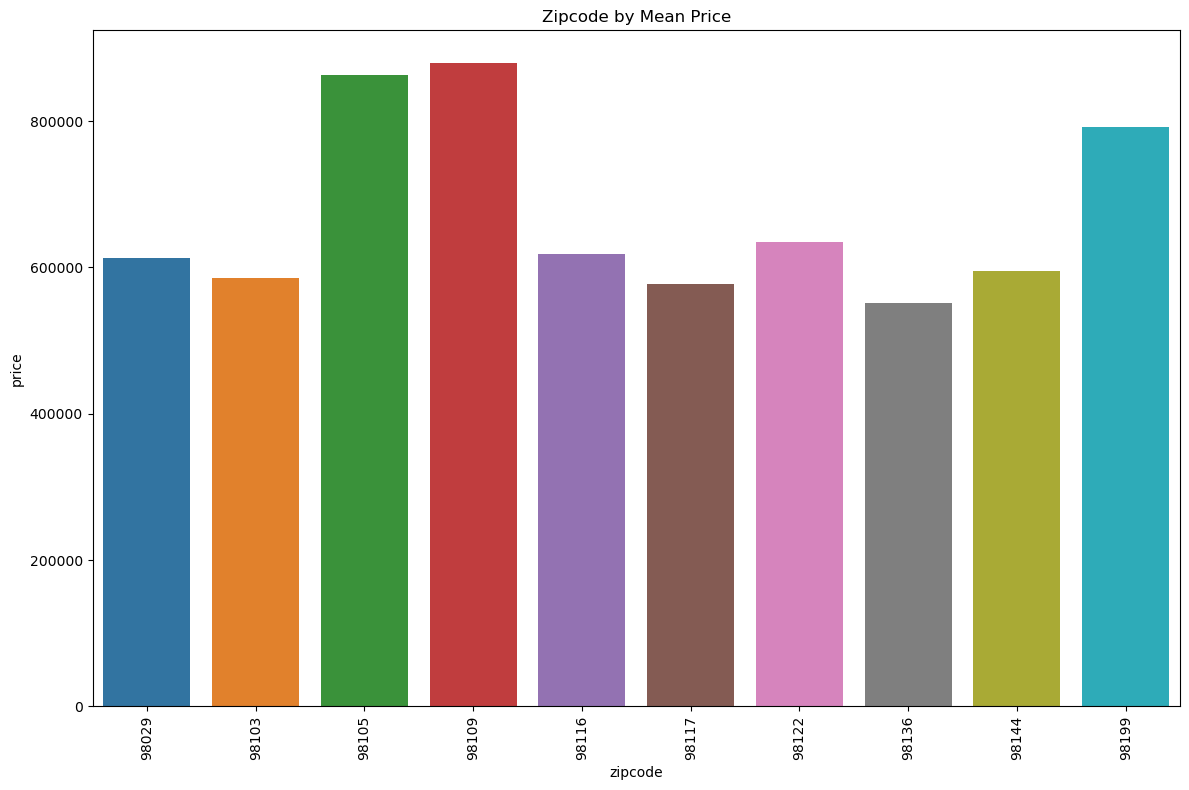

In [34]:
# mean price per zipcode
# removed both extremes to extract zipcodes containing mid-range prices to maintain desirability
# expensive neighborhoods are desirable but not a lot of people can afford it, cheapest neighborhoods are very affordable 
# but renting out/selling houses in these neighborhoods does not exactly equate to a high return on investment or it usually
# takes longer to make your ROI back

fig, ax = plt.subplots(figsize = (12, 8))

sns.barplot(data = df_by_zipcode_mean_shrunked, 
            x = df_by_zipcode_mean_shrunked.index, 
            y = "price",
            estimator = np.mean,
            ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.title("Zipcode by Mean Price")
plt.tight_layout()
plt.show();

In [35]:
df_by_zipcode_top5_cheapest = df_by_zipcode_mean.nsmallest(5, "price")
df_by_zipcode_top5_priciest = df_by_zipcode_mean.nlargest(5, "price")
print(df_by_zipcode_top5_cheapest)
print(df_by_zipcode_top5_priciest)

                 price  bedrooms  bathrooms  sqft_living      sqft_lot  \
zipcode                                                                  
98023    286742.811623  3.424850   2.061623  1989.729459  10470.208417   
98188    289078.345588  3.433824   1.863971  1802.772059  10126.080882   
98030    296187.980469  3.500000   2.162109  1962.500000  11778.734375   
98042    311580.336380  3.404022   2.126143  1981.696527  18974.215722   
98022    316742.390558  3.158798   1.918455  1837.313305  74233.914163   

              FAR     grade  condition      view  month  
zipcode                                                  
98023    0.225001  7.575150   3.386774  0.118236    499  
98188    0.194529  7.036765   3.330882  0.147059    136  
98030    0.252976  7.414062   3.289062  0.023438    256  
98042    0.244047  7.424132   3.519196  0.032907    547  
98022    0.139566  7.175966   3.733906  0.630901    233  
                 price  bedrooms  bathrooms  sqft_living      sqft_lot  \
z

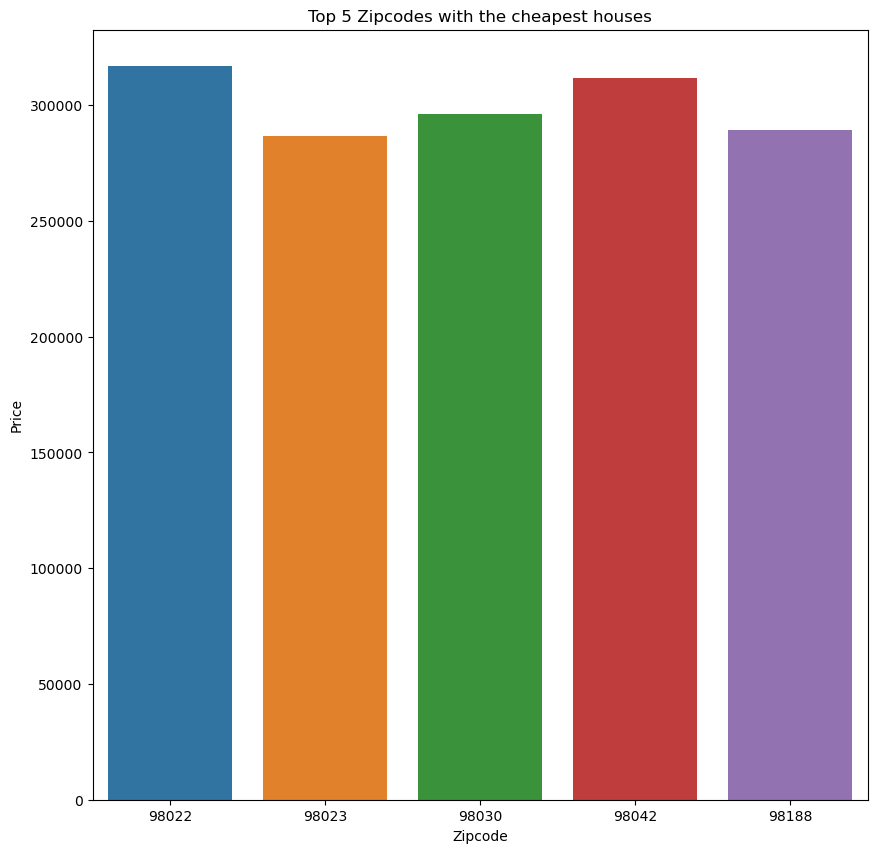

In [36]:
# barplot of top 5 cheapest houses by zipcode using mean price
fig, ax = plt.subplots(figsize = (10, 10))

sns.barplot(data = df_by_zipcode_top5_cheapest,
            x = df_by_zipcode_top5_cheapest.index,
            y = "price", 
            ax = ax)
plt.xlabel("Zipcode")
plt.ylabel("Price")
plt.title("Top 5 Zipcodes with the cheapest houses")
plt.show();


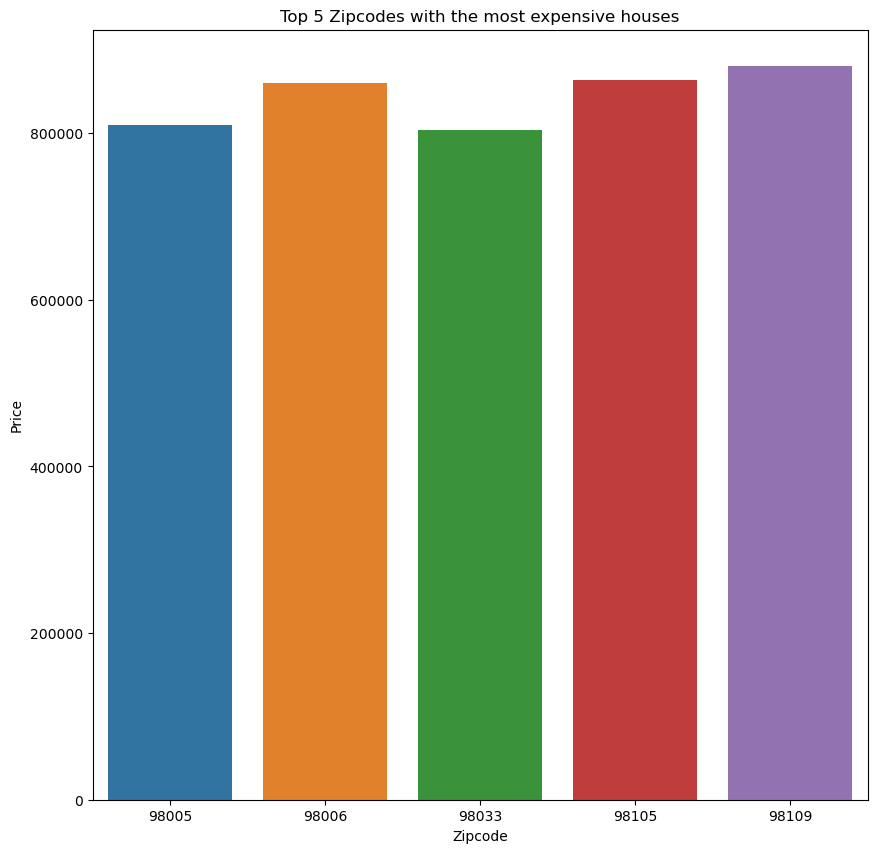

In [37]:
fig, ax = plt.subplots(figsize = (10, 10))

sns.barplot(data = df_by_zipcode_top5_priciest,
            x = df_by_zipcode_top5_priciest.index,
            y = "price", 
            ax = ax)
plt.xlabel("Zipcode")
plt.ylabel("Price")
plt.title("Top 5 Zipcodes with the most expensive houses")
plt.show();

In [38]:
# modified dataframe 
df1_filtered_by_unique_zips

id       date      price  bedrooms  bathrooms  sqft_living  \
1      6414100192 2014-12-09   538000.0         3       2.25         2570   
3      2487200875 2014-12-09   604000.0         4       3.00         1960   
4      1954400510 2015-02-18   510000.0         3       2.00         1680   
5      7237550310 2014-05-12  1230000.0         4       4.50         5420   
9      3793500160 2015-03-12   323000.0         3       2.50         1890   
...           ...        ...        ...       ...        ...          ...   
21591  2997800021 2015-02-19   475000.0         3       2.50         1310   
21592   263000018 2014-05-21   360000.0         3       2.50         1530   
21594  1523300141 2014-06-23   402101.0         2       0.75         1020   
21595   291310100 2015-01-16   400000.0         3       2.50         1600   
21596  1523300157 2014-10-15   325000.0         2       0.75         1020   

       sqft_lot  floors  waterfront  view  ...  yr_built  zipcode      lat  \
1          7242     2.0           0     0  ...      1951    98125  47.7210   
3          5000     1.0           0     0  ...      1965    98136  47.5208   
4          8080     1.0           0     0  ...      1987    98074  47.6168   
5        101930     1.0           0     0  ...      2001    98053  47.6561   
9          6560     2.0           0     0  ...      2003    98038  47.3684   
...         ...     ...         ...   ...  ...       ...      ...      ...   
21591      1294     2.0           0     0  ...      2008    98116  47.5773   
21592      1131     3.0           0     0  ...      2009    98103  47.6993   
21594      1350     2.0           0     0  ...      2009    98144  47.5944   
21595      2388     2.0           0     0  ...      2004    98027  47.5345   
21596      1076     2.0           0     0  ...      2008    98144  47.5941   

          long  sqft_living15  sqft_lot15       FAR  year_renovated  zoning  \
1     -122.319           1690        7639  0.354874               1       1   
3     -122.393           1360        5000  0.392000               0       1   
4     -122.045           1800        7503  0.207921               0       1   
5     -122.005           4760      101930  0.053174               0       1   
9     -122.031           2390        7570  0.288110               0       1   
...        ...            ...         ...       ...             ...     ...   
21591 -122.409           1330        1265  1.012365               0       2   
21592 -122.346           1530        1509  1.352785               0       2   
21594 -122.299           1020        2007  0.755556               0       2   
21595 -122.069           1410        1287  0.670017               0       2   
21596 -122.299           1020        1357  0.947955               0       2   

       month  
1         12  
3         12  
4          2  
5          5  
9          3  
...      ...  
21591      2  
21592      5  
21594      6  
21595      1  
21596     10  

[14890 rows x 24 columns]

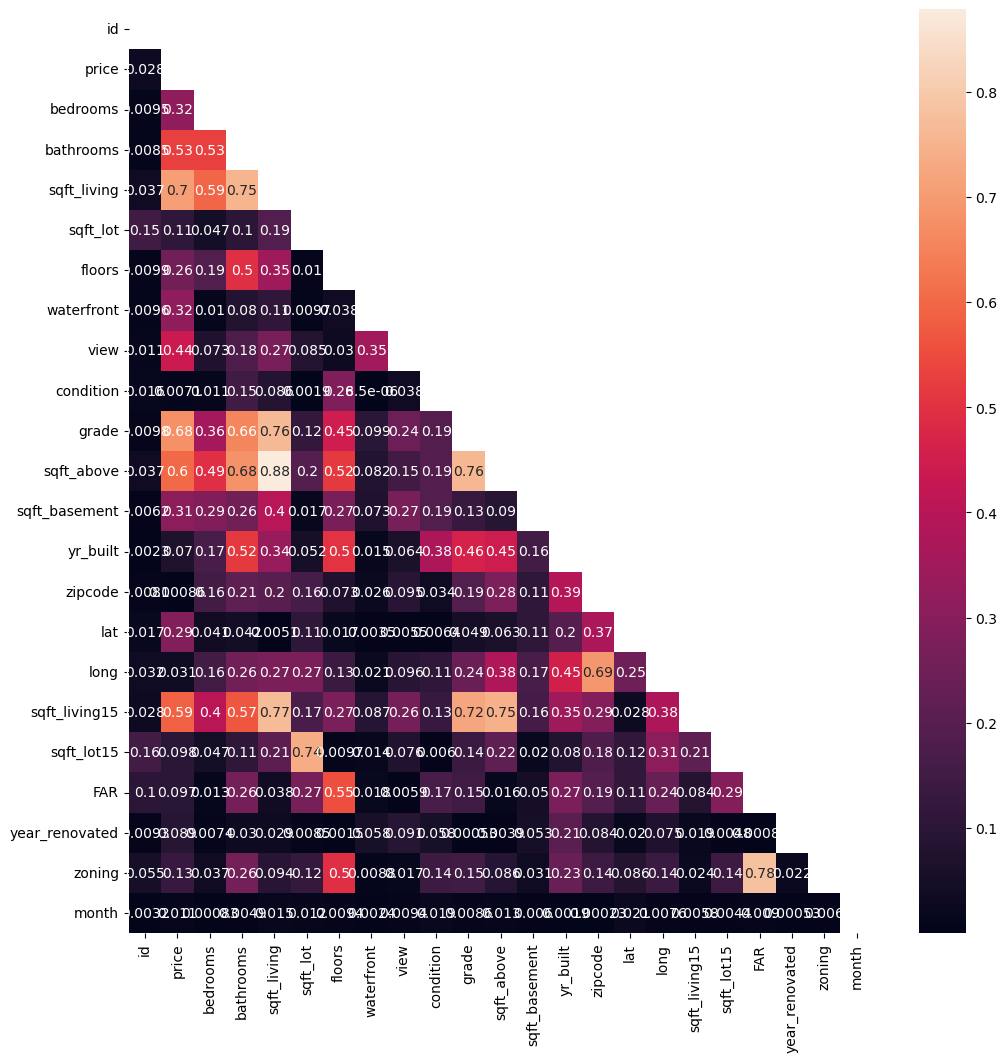

In [39]:
fig, ax = plt.subplots(figsize = (12, 12))
mask = np.triu(np.ones_like(df1_filtered_by_unique_zips.corr()))
sns.heatmap(df1_filtered_by_unique_zips.corr().abs(), annot = True, mask = mask)
plt.show();

# HIGHLY CORRELATED VARIABLES 

#sqft_living and sqft_above
#sqft_living and sqft_living15
#sqft_lot and sqft_lot15
#sqft_living15 and sqft_above
#FAR and Zoning



# Getting rid of:

#sqft_living15
#sqft_lot15
#sqft_above
#date
#id
#zoning

In [40]:
#df1_filtered_by_unique_zips = df1_filtered_by_unique_zips.drop(columns = ["sqft_living15", "sqft_lot15", "sqft_above", "id"])

In [41]:
df1_filtered_by_unique_zips.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'FAR', 'year_renovated', 'zoning',
       'month'],
      dtype='object')

# Base Model of all Numerical Features without OHE

In [42]:
# train test split 
# base (every single feature included)
columns = ['zipcode', 'bathrooms', 'sqft_living',
       'sqft_lot', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'FAR', "lat"]

X = df1_filtered_by_unique_zips[columns]
y = np.log(df1_filtered_by_unique_zips["price"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42) 

In [43]:
# standard scaler 

ss = StandardScaler()

ss.fit(X_train)
X_standardized_train = ss.transform(X_train)
X_standardized_test = ss.transform(X_test)

X_standardized_train.mean(axis = 0)
X_standardized_train.std(axis = 0)

X_standardized_test.mean(axis = 0)
X_standardized_test.std(axis = 0)

array([0.98716536, 0.99667088, 0.97438005, 0.97999843, 0.91954399,
       0.94670546, 0.99128074, 0.97272205, 0.98628838, 0.98729449,
       0.98727427, 1.01055151])

In [44]:
lr1 = LinearRegression()

lr1.fit(X_train, y_train)

r2_train = lr1.score(X_train, y_train)
r2_test = lr1.score(X_test, y_test)

prediction = lr1.predict(X_test)

rsquared = r2_score(y_test, prediction)
mean_sq_error = mean_squared_error(y_test, prediction, squared = False)

print("Rsquared: ", rsquared)
print("Mean_Sq_Error: ", mean_sq_error)

print("1st Model Train R Squared: ", r2_train)
print("1st Model Test R Squared: ", r2_test)

Rsquared:  0.7401416911248855
Mean_Sq_Error:  0.23953761248961472
1st Model Train R Squared:  0.7346113949335462
1st Model Test R Squared:  0.7401416911248855


In [45]:
# showing first model using a scatterplot

fig = px.scatter(x = prediction ,y = y_test, trendline = 'ols', labels = {"y": "log_price"})
fig.show('notebook')

In [45]:
# coefficients

[('zipcode', 36.25538331767506),
 ('bedrooms', -20187.264197238637),
 ('bathrooms', 806.092186620338),
 ('sqft_living', 102.00163694782748),
 ('sqft_lot', 0.03770040971721755),
 ('floors', -28657.492623229107),
 ('waterfront', 704363.2473289178),
 ('view', 78246.68197030413),
 ('condition', 45397.53217339846),
 ('grade', 74083.12731459619),
 ('sqft_above', 62.39655353452849),
 ('sqft_basement', 39.60508346211827),
 ('FAR', 63634.91175166547),
 ('lat', 608358.4566116292)]

[('zipcode', 36.25538331767506),
 ('bedrooms', -20187.264197238637),
 ('bathrooms', 806.092186620338),
 ('sqft_living', 102.00163694782748),
 ('sqft_lot', 0.03770040971721755),
 ('floors', -28657.492623229107),
 ('waterfront', 704363.2473289178),
 ('view', 78246.68197030413),
 ('condition', 45397.53217339846),
 ('grade', 74083.12731459619),
 ('sqft_above', 62.39655353452849),
 ('sqft_basement', 39.60508346211827),
 ('FAR', 63634.91175166547),
 ('lat', 608358.4566116292)]

# One Hot Encode

In [46]:
X_train.columns

Index(['zipcode', 'bathrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'FAR', 'lat'],
      dtype='object')

In [47]:
from sklearn.preprocessing import OneHotEncoder


ohe = OneHotEncoder(handle_unknown = "ignore")
ohe_train = ohe.fit_transform(X_train[["zipcode"]]).toarray()
ohe_test = ohe.transform(X_test[["zipcode"]]).toarray()

In [48]:
ohe_train = pd.DataFrame(ohe_train, columns = ohe.get_feature_names())
ohe_test = pd.DataFrame(ohe_test, columns = ohe.get_feature_names())


ohe_train.index = X_train.index
ohe_test.index = X_test.index
X_train = pd.concat([X_train, ohe_train],1)
X_test = pd.concat([X_test, ohe_test],1)

C:\Users\jocel\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

C:\Users\jocel\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

C:\Users\jocel\AppData\Local\Temp\ipykernel_14716\1270744369.py:7: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.

C:\Users\jocel\AppData\Local\Temp\ipykernel_14716\1270744369.py:8: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.



In [49]:
X_train.drop(columns =["zipcode"], inplace = True)
X_test.drop(columns =["zipcode"], inplace = True)

# Model of all Numerical Features with OHE

In [50]:
lr2 = LinearRegression()

lr2.fit(X_train, y_train)

r2_train = lr2.score(X_train, y_train)
r2_test = lr2.score(X_test, y_test)

prediction = lr2.predict(X_test)
rsquared = r2_score(y_test, prediction)
mean_sq_error = mean_squared_error(y_test, prediction, squared = False)

print("2nd Model R Train Squared: ", r2_train)
print("2nd Model R Test Squared: ", r2_test)
print("Mean Square Error: ", mean_sq_error)

2nd Model R Train Squared:  0.8438939518230089
2nd Model R Test Squared:  0.8518512376956039
Mean Square Error:  0.18086495574301714


In [51]:
fig = px.scatter(x = prediction ,y = y_test, trendline = 'ols', labels = {"y": "log_price"})
fig.show('notebook')